# OpenCV

## 이미지 데이터 구조의 이해

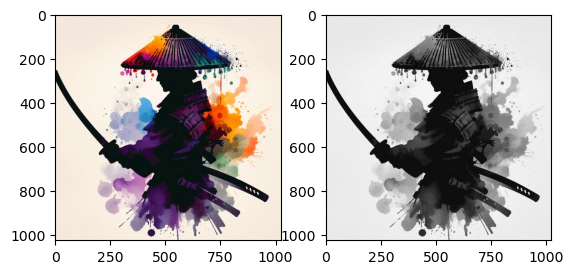

In [4]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

color_img = np.asarray(Image.open('assets/Designer.jpg'))
gray_img = np.mean(color_img, axis=2).astype(np.uint8)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(color_img)
ax[1].imshow(gray_img, cmap='gray')

## OpenCV vs Pillow
- 요약: OpenCV가 빠르다.

## 크기 조절

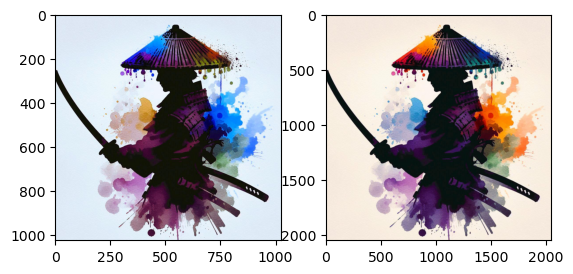

In [5]:
import cv2
import matplotlib.pyplot as plt
img = cv2.imread('assets/Designer.jpg')
img2 = cv2.resize(img, None, fx=2, fy=2)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(img)
ax[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))

## 회전

`rotate(src, rotateCode[,dst])`



In [6]:
import cv2
import numpy as np

# 원본 이미지
img = cv2.imread('assets/Designer.jpg')

# 이미지 중심 좌표
# shape에선 height 먼저 나온다
(h, w) = img.shape[:2]
center = (w // 2, h // 2)

# 회전 행렬 (45도 회전 + 0.5배 확대)
# 이미지 변경방법을 행렬을 통해 표현하고, 이 행렬을 warpAffine에 넣는다.
M = cv2.getRotationMatrix2D(center=center, angle=45, scale=0.5)

# Affine 변환 적용
rotated = cv2.warpAffine(img, M, (w, h))

# 출력
cv2.imshow('Rotated Image', rotated)
cv2.waitKey(0)
cv2.destroyAllWindows()


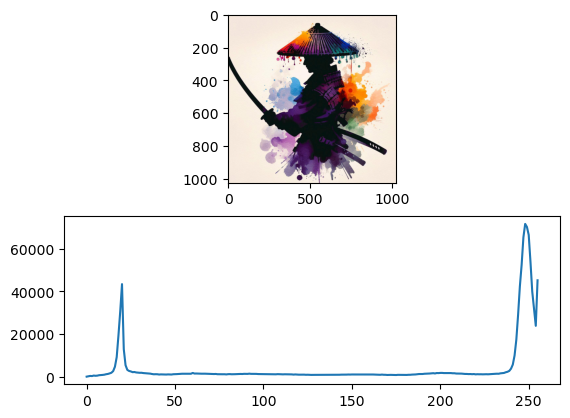

In [7]:
import cv2
import matplotlib.pyplot as plt

def show_histogram(hsv):
    h,s,v = cv2.split(hsv)
    hist = cv2.calcHist([v], [0], None, [256], [0, 256])
    ax = plt.subplot(2,1,2)
    ax.plot(hist)
    ax = plt.subplot(2,1,1)
    ax.imshow(cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB))
    plt.show()
    
img = cv2.imread('assets/Designer.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
show_histogram(hsv)

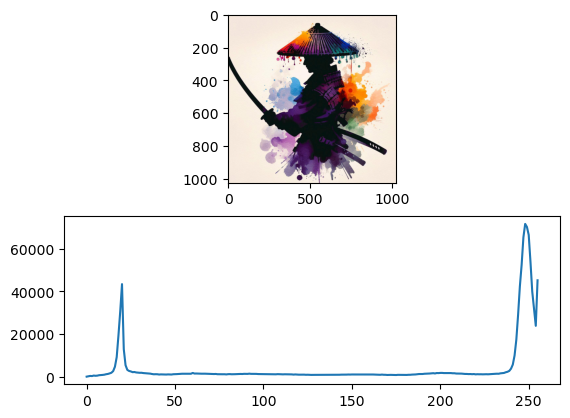

In [8]:
h,s,v = cv2.split(hsv)
v_norm= cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
hsv_norm = cv2.merge((h,s,v_norm))
show_histogram(hsv_norm)

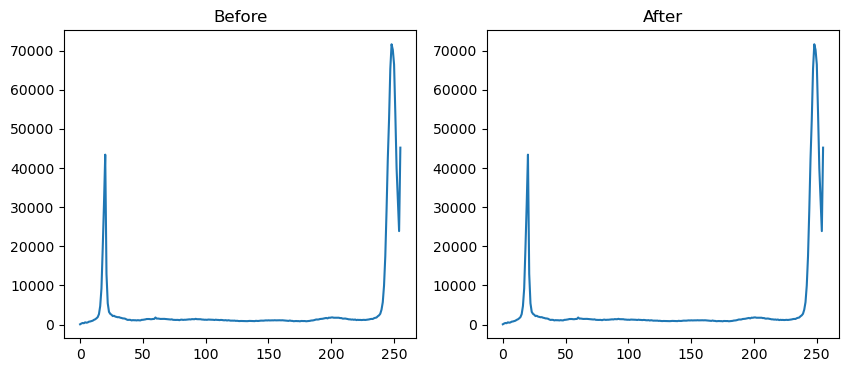

In [9]:
import cv2
import matplotlib.pyplot as plt

img = cv2.imread('assets/Designer.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h, s, v = cv2.split(hsv)

# 정규화
v_norm = cv2.normalize(v, None, 0, 255, cv2.NORM_MINMAX)
hsv_norm = cv2.merge((h, s, v_norm))

# 히스토그램 확인 함수
def show_histogram(v_before, v_after):
    hist1 = cv2.calcHist([v_before], [0], None, [256], [0, 256])
    hist2 = cv2.calcHist([v_after], [0], None, [256], [0, 256])
    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1); plt.plot(hist1); plt.title('Before')
    plt.subplot(1,2,2); plt.plot(hist2); plt.title('After')
    plt.show()

show_histogram(v, v_norm)


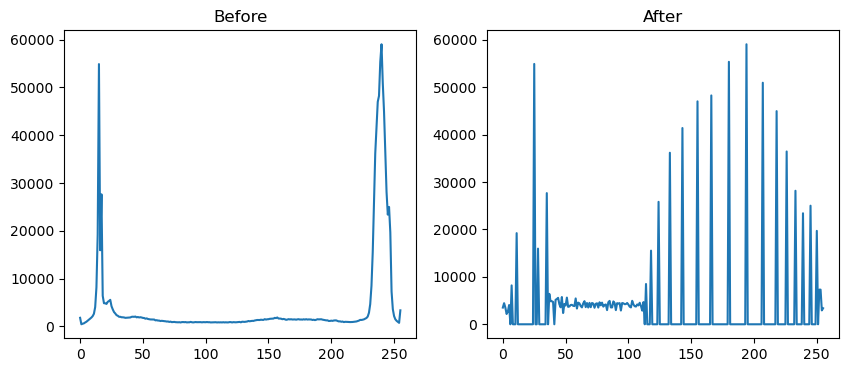

In [10]:
img = cv2.imread('assets/Designer.jpg', cv2.IMREAD_GRAYSCALE)
img_equalized = cv2.equalizeHist(img)   

hist = cv2.calcHist([img], [0], None, [256], [0, 256])
hist_equalized = cv2.calcHist([img_equalized], [0], None, [256], [0, 256])

plt.figure(figsize=(10,4))
for i, h in enumerate([hist, hist_equalized]):
    plt.subplot(1,2,i+1)
    plt.plot(h)
    plt.title('Before' if i == 0 else 'After')
plt.show()
cv2.imshow('Original Grayscale', img)
cv2.imshow('Equalized Grayscale', img_equalized)
cv2.waitKey(0)
cv2.destroyAllWindows()

### 실습


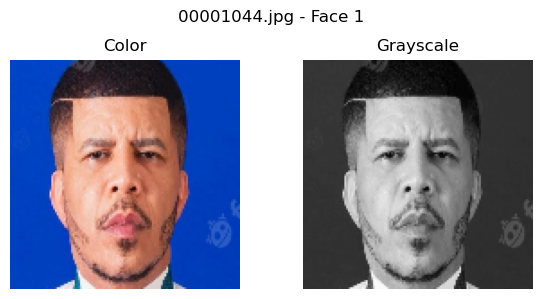

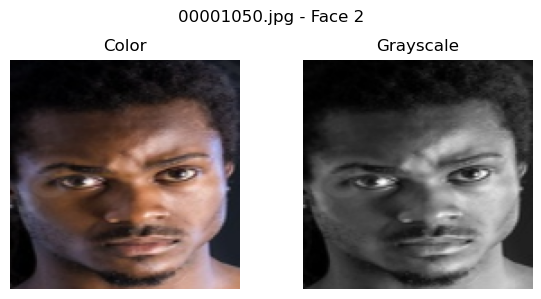

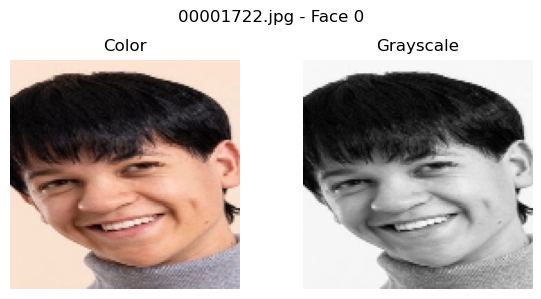

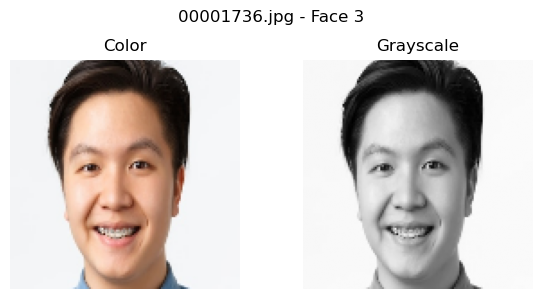

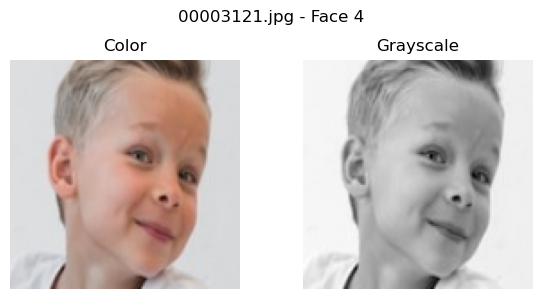

✅ 전처리 완료


In [ ]:
import cv2
import pandas as pd
import os
import matplotlib.pyplot as plt

# 경로 설정
csv_path = "./faces.csv"
image_folder = "./assets"
target_size = (128, 128)
save_folder_gray = "./processed"
save_folder_color = "./processed_color"

# 저장 경로 생성
os.makedirs(save_folder_gray, exist_ok=True)
os.makedirs(save_folder_color, exist_ok=True)

# CSV 불러오기
df = pd.read_csv(csv_path)

# 이미지별 그룹 처리
grouped = df.groupby("image_name")

for image_name, group in grouped:
    image_path = os.path.join(image_folder, image_name)
    img = cv2.imread(image_path)

    if img is None:
        print(f"❌ 이미지 로드 실패: {image_name}")
        continue

    height, width = img.shape[:2]

    for i, row in group.iterrows():
        # 좌표 추출 및 유효성 보정
        x0 = max(0, min(width, int(row['x0'])))
        y0 = max(0, min(height, int(row['y0'])))
        x1 = max(0, min(width, int(row['x1'])))
        y1 = max(0, min(height, int(row['y1'])))

        if x1 <= x0 or y1 <= y0:
            print(f"⚠️ 잘못된 좌표: {image_name} → ({x0},{y0}) to ({x1},{y1})")
            continue

        # 얼굴 자르기 → 크기 조절
        face = img[y0:y1, x0:x1]
        try:
            resized_face = cv2.resize(face, target_size)
            gray_face = cv2.cvtColor(resized_face, cv2.COLOR_BGR2GRAY)
        except Exception as e:
            print(f"⚠️ 처리 오류: {image_name} - 얼굴 {i} → {e}")
            continue

        # 시각화
        if i < 5:
            fig, axes = plt.subplots(1, 2, figsize=(6, 3))  # 가로 2개
            fig.suptitle(f"{image_name} - Face {i}")

            axes[0].imshow(cv2.cvtColor(resized_face, cv2.COLOR_BGR2RGB))
            axes[0].set_title("Color")
            axes[0].axis('off')

            axes[1].imshow(gray_face, cmap='gray')
            axes[1].set_title("Grayscale")
            axes[1].axis('off')

            plt.tight_layout()
            plt.show()
            
        # 저장 경로 설정
        base_name = os.path.splitext(image_name)[0]
        gray_path = os.path.join(save_folder_gray, f"{base_name}_face{i}.png")
        color_path = os.path.join(save_folder_color, f"{base_name}_face{i}_color.png")

        # 저장
        cv2.imwrite(gray_path, gray_face)
        cv2.imwrite(color_path, resized_face)

print("✅ 전처리 완료")


메모리에 전처리한 이미지들을 임시 저장하는 코드

✅ 3350개의 얼굴 이미지가 메모리에 저장되었습니다.


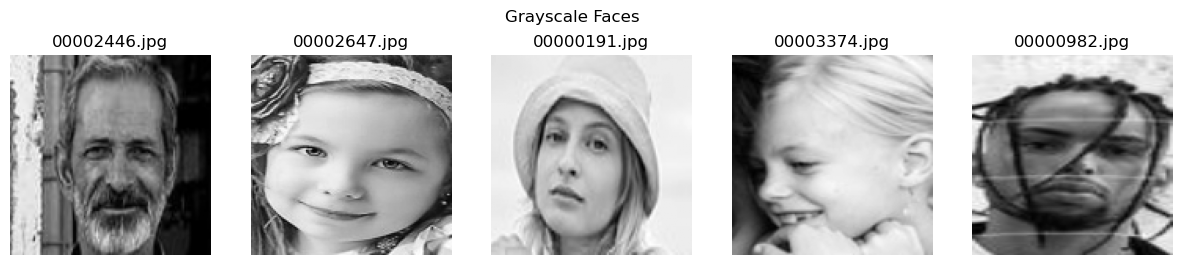

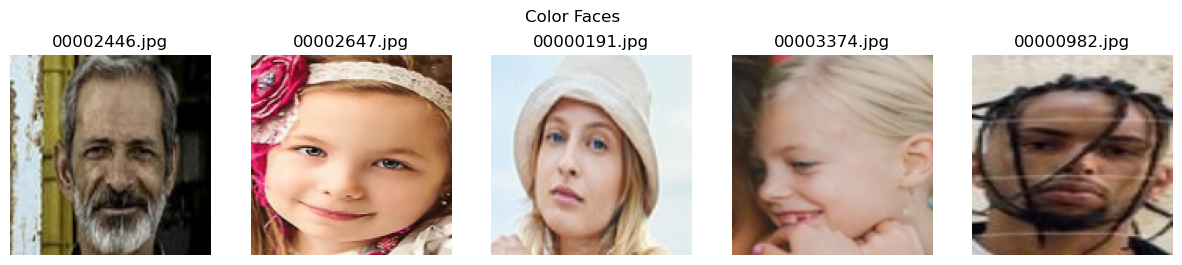

In [ ]:
import cv2, os, random
import pandas as pd
import matplotlib.pyplot as plt

# 설정
csv_path = "./faces.csv"
image_folder = "./assets"
target_size = (128, 128)
processed_images = []  # 전처리된 이미지 저장용

# CSV 불러오기
df = pd.read_csv(csv_path)
grouped = df.groupby("image_name")

# 전처리 & 메모리 저장
for image_name, group in grouped:
    img_path = os.path.join(image_folder, image_name)
    img = cv2.imread(img_path)
    if img is None:
        continue

    h, w = img.shape[:2]
    for i, row in group.iterrows():
        x0 = max(0, min(w, int(row['x0'])))
        y0 = max(0, min(h, int(row['y0'])))
        x1 = max(0, min(w, int(row['x1'])))
        y1 = max(0, min(h, int(row['y1'])))

        if x1 <= x0 or y1 <= y0:
            continue

        face = img[y0:y1, x0:x1]
        try:
            color = cv2.resize(face, target_size)
            gray = cv2.cvtColor(color, cv2.COLOR_BGR2GRAY)
        except:
            continue

        processed_images.append({
            "file": image_name,
            "gray": gray,
            "color": color
        })

print(f"✅ {len(processed_images)}개의 얼굴 이미지가 메모리에 저장되었습니다.")

# 🎲 시각화: 무작위 5장 추출
sample = random.sample(processed_images, min(5, len(processed_images)))

# 흑백 나열
plt.figure(figsize=(15, 3))
for i, item in enumerate(sample):
    plt.subplot(1, 5, i+1)
    plt.imshow(item['gray'], cmap='gray')
    plt.title(f"{item['file']}")
    plt.axis('off')
plt.suptitle("Grayscale Faces")
plt.show()

# 컬러 나열
plt.figure(figsize=(15, 3))
for i, item in enumerate(sample):
    plt.subplot(1, 5, i+1)
    plt.imshow(cv2.cvtColor(item['color'], cv2.COLOR_BGR2RGB))
    plt.title(f"{item['file']}")
    plt.axis('off')
plt.suptitle("Color Faces")
plt.show()

# 객체 정리
processed_images.clear()



처리된 이미지의 그래프화

파일: 00000506_face1539_color.png
평균: 132.41, 표준편차: 74.76, 분산: 5589.34, 엔트로피: 7.90


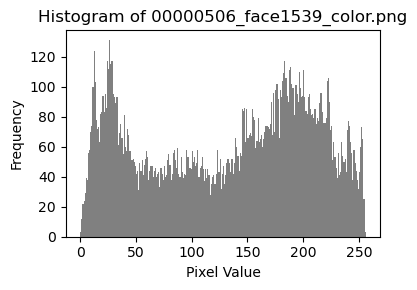

파일: 00000841_face1393_color.png
평균: 153.91, 표준편차: 47.84, 분산: 2288.73, 엔트로피: 7.23


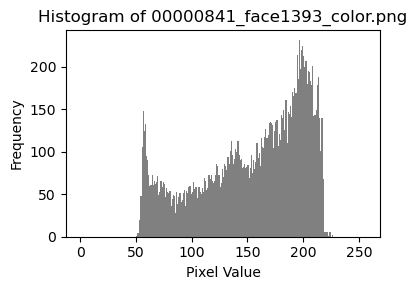

파일: 00000540_face2638_color.png
평균: 116.47, 표준편차: 68.01, 분산: 4625.71, 엔트로피: 7.86


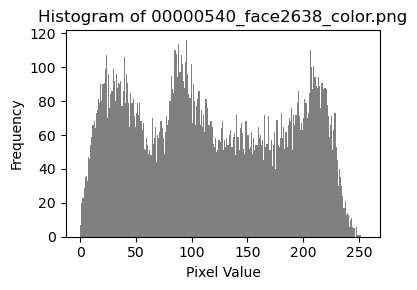

파일: 00001154_face1341_color.png
평균: 133.78, 표준편차: 53.49, 분산: 2861.23, 엔트로피: 7.68


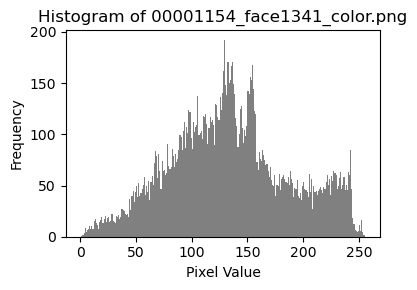

파일: 00000657_face1901_color.png
평균: 109.49, 표준편차: 66.24, 분산: 4387.50, 엔트로피: 7.66


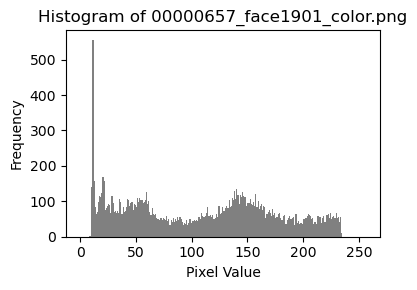

파일: 00002573_face435_color.png
평균: 143.81, 표준편차: 57.75, 분산: 3334.56, 엔트로피: 7.65


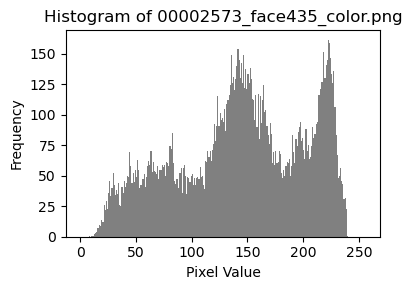

파일: 00002718_face1835_color.png
평균: 152.60, 표준편차: 49.84, 분산: 2484.30, 엔트로피: 7.47


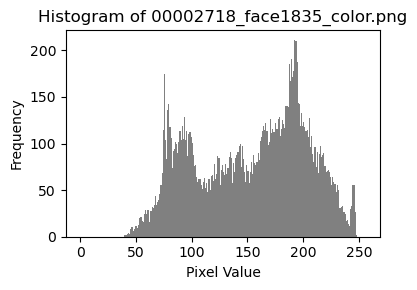

파일: 00000609_face2915_color.png
평균: 107.38, 표준편차: 65.03, 분산: 4229.33, 엔트로피: 7.75


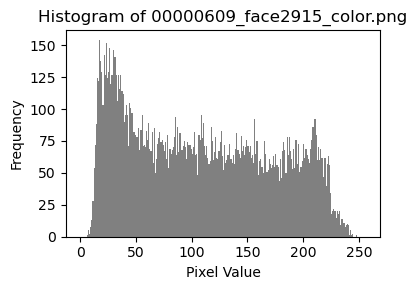

파일: 00000753_face3289_color.png
평균: 118.02, 표준편차: 78.67, 분산: 6188.23, 엔트로피: 6.96


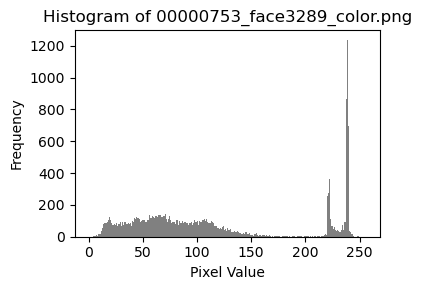

파일: 00002030_face3317_color.png
평균: 105.32, 표준편차: 36.90, 분산: 1361.87, 엔트로피: 7.14


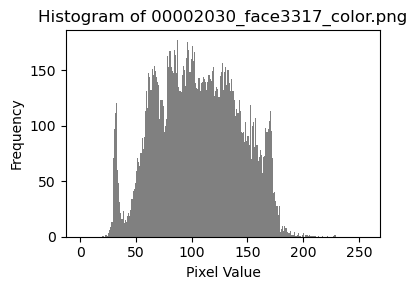

In [24]:
import cv2, os, random
import numpy as np
import matplotlib.pyplot as plt


def cal_entropy(image):
    hist = cv2.calcHist([image], [0], None, [256], [0, 256])
    hist_norm = hist.ravel() / hist.sum()
    hist_norm = hist_norm[hist_norm > 0]
    entropy = -np.sum(hist_norm * np.log2(hist_norm))
    return entropy

# 이미지 폴더 경로
folder_path = "./processed_color"
image_files = [f for f in  os.listdir(folder_path) if f.endswith(('.jpg', '.png', '.jpeg'))]

max_sample = 10
sample_files = random.sample(image_files, min(max_sample, len(image_files)))


# 반복처리
for file in sample_files:
    file_path = os.path.join(folder_path, file)
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"❌ 이미지 로드 실패: {file}")
        continue
    
    # 수치 분석
    mean_val = np.mean(img)
    std_val = np.std(img)
    var_val = np.var(img)
    entropy_val = cal_entropy(img)
    
    print(f"파일: {file}")
    print(f"평균: {mean_val:.2f}, 표준편차: {std_val:.2f}, 분산: {var_val:.2f}, 엔트로피: {entropy_val:.2f}")
    
    # 시각화
    plt.figure(figsize=(4,3))
    plt.hist(img.ravel(), bins=256, range=[0, 256], color='gray')
    plt.title(f"Histogram of {file}")   
    plt.xlabel('Pixel Value')
    plt.ylabel('Frequency')
    plt.tight_layout()
    # plt.savefig(f"./histograms/{file}_histogram.png")
    plt.show()